COMPREHENSIVE RIEMANNIAN MANIFOLD DISTANCE APPROXIMATION EXPERIMENT

TESTING: Hyperbolic (Poincaré Disk)
Testing 196 point pairs on Hyperbolic (Poincaré Disk) manifold...

=== Results Summary for Hyperbolic (Poincaré Disk) Manifold ===
Method               MAE        Max AE     MRE        Max RE     RMSE       Time (ms)   
--------------------------------------------------------------------------------------------
linear_interpolation 0.0185     0.1450     0.0085     0.0512     0.0390     0.6390      
midpoint             0.0984     0.6724     0.0413     0.1936     0.1849     0.0077      
weighted_midpoint    0.0415     0.2273     0.0166     0.0736     0.0795     0.0190      
endpoint_average     0.3284     2.0186     0.1358     0.5815     0.6013     0.0102      
euclidean            0.8257     2.0724     0.5630     0.7077     1.0056     0.0032      
Generating manifold curvature visualization...


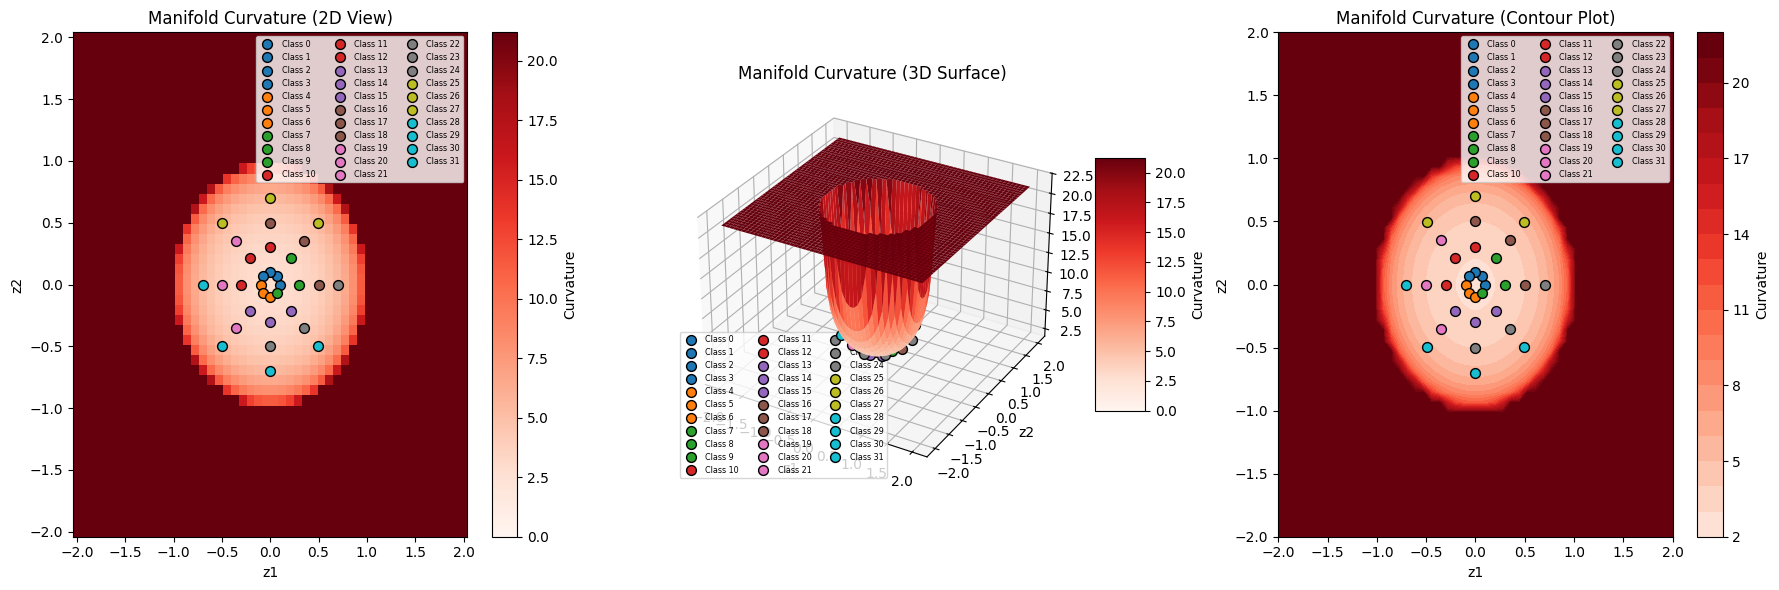

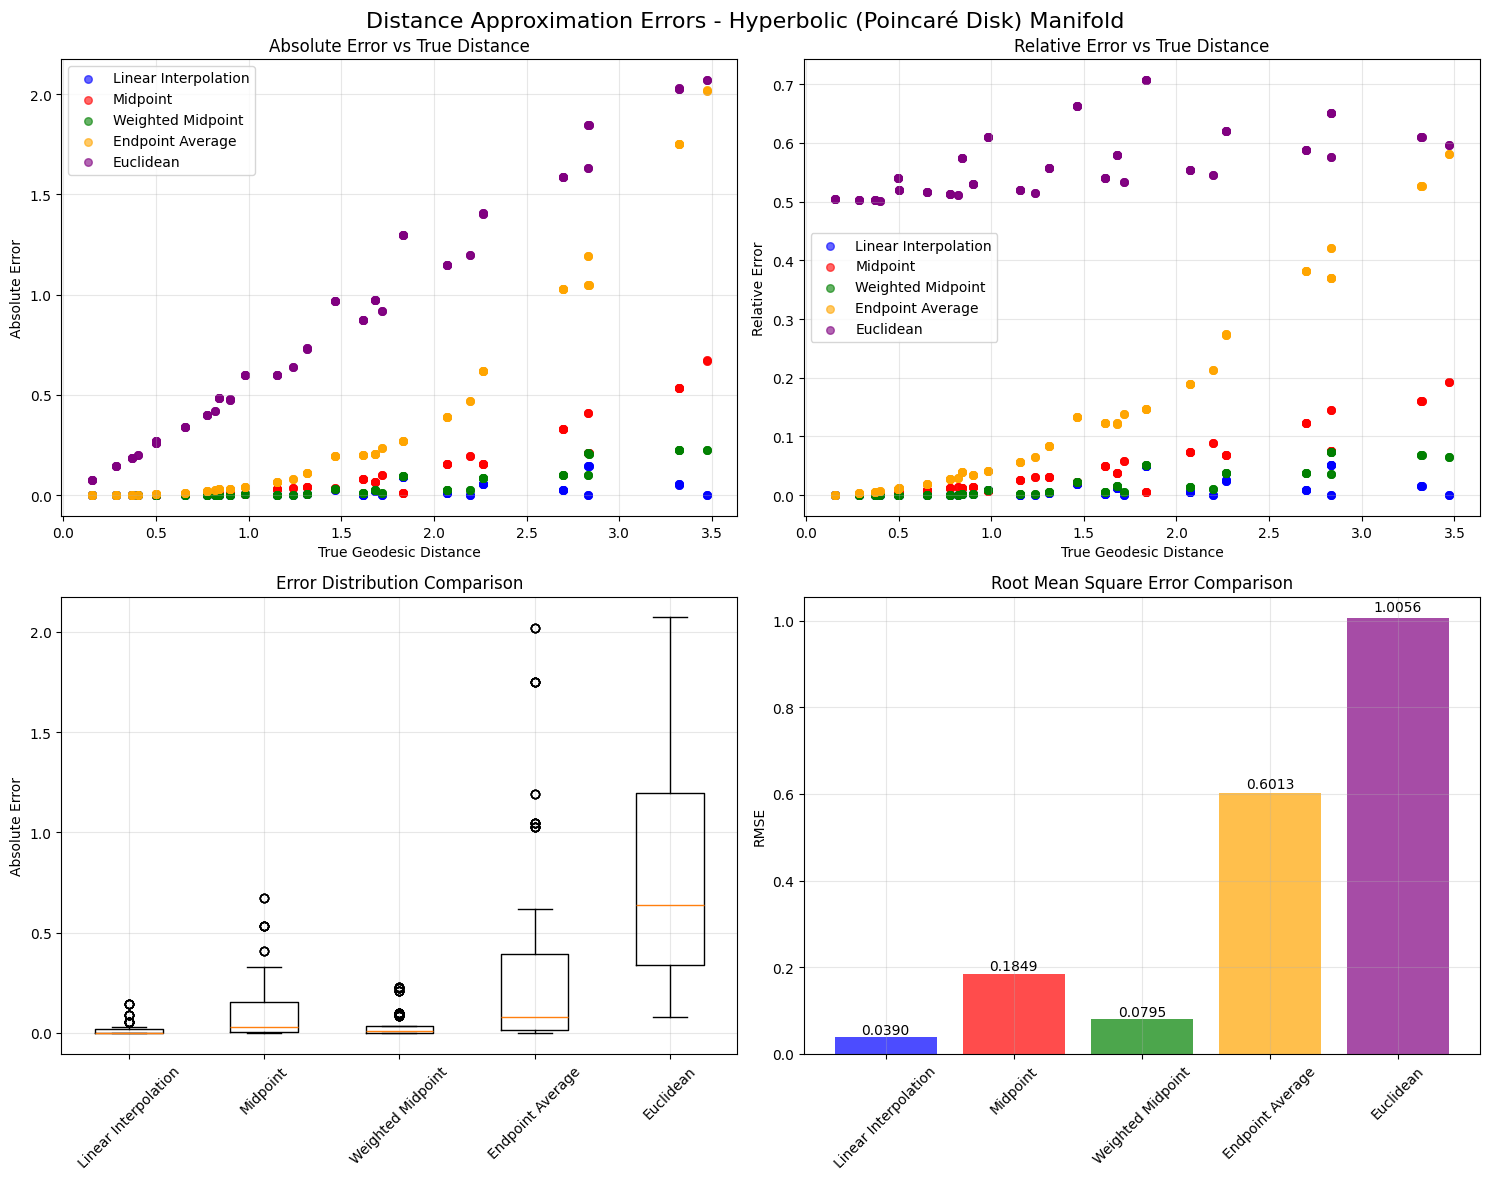

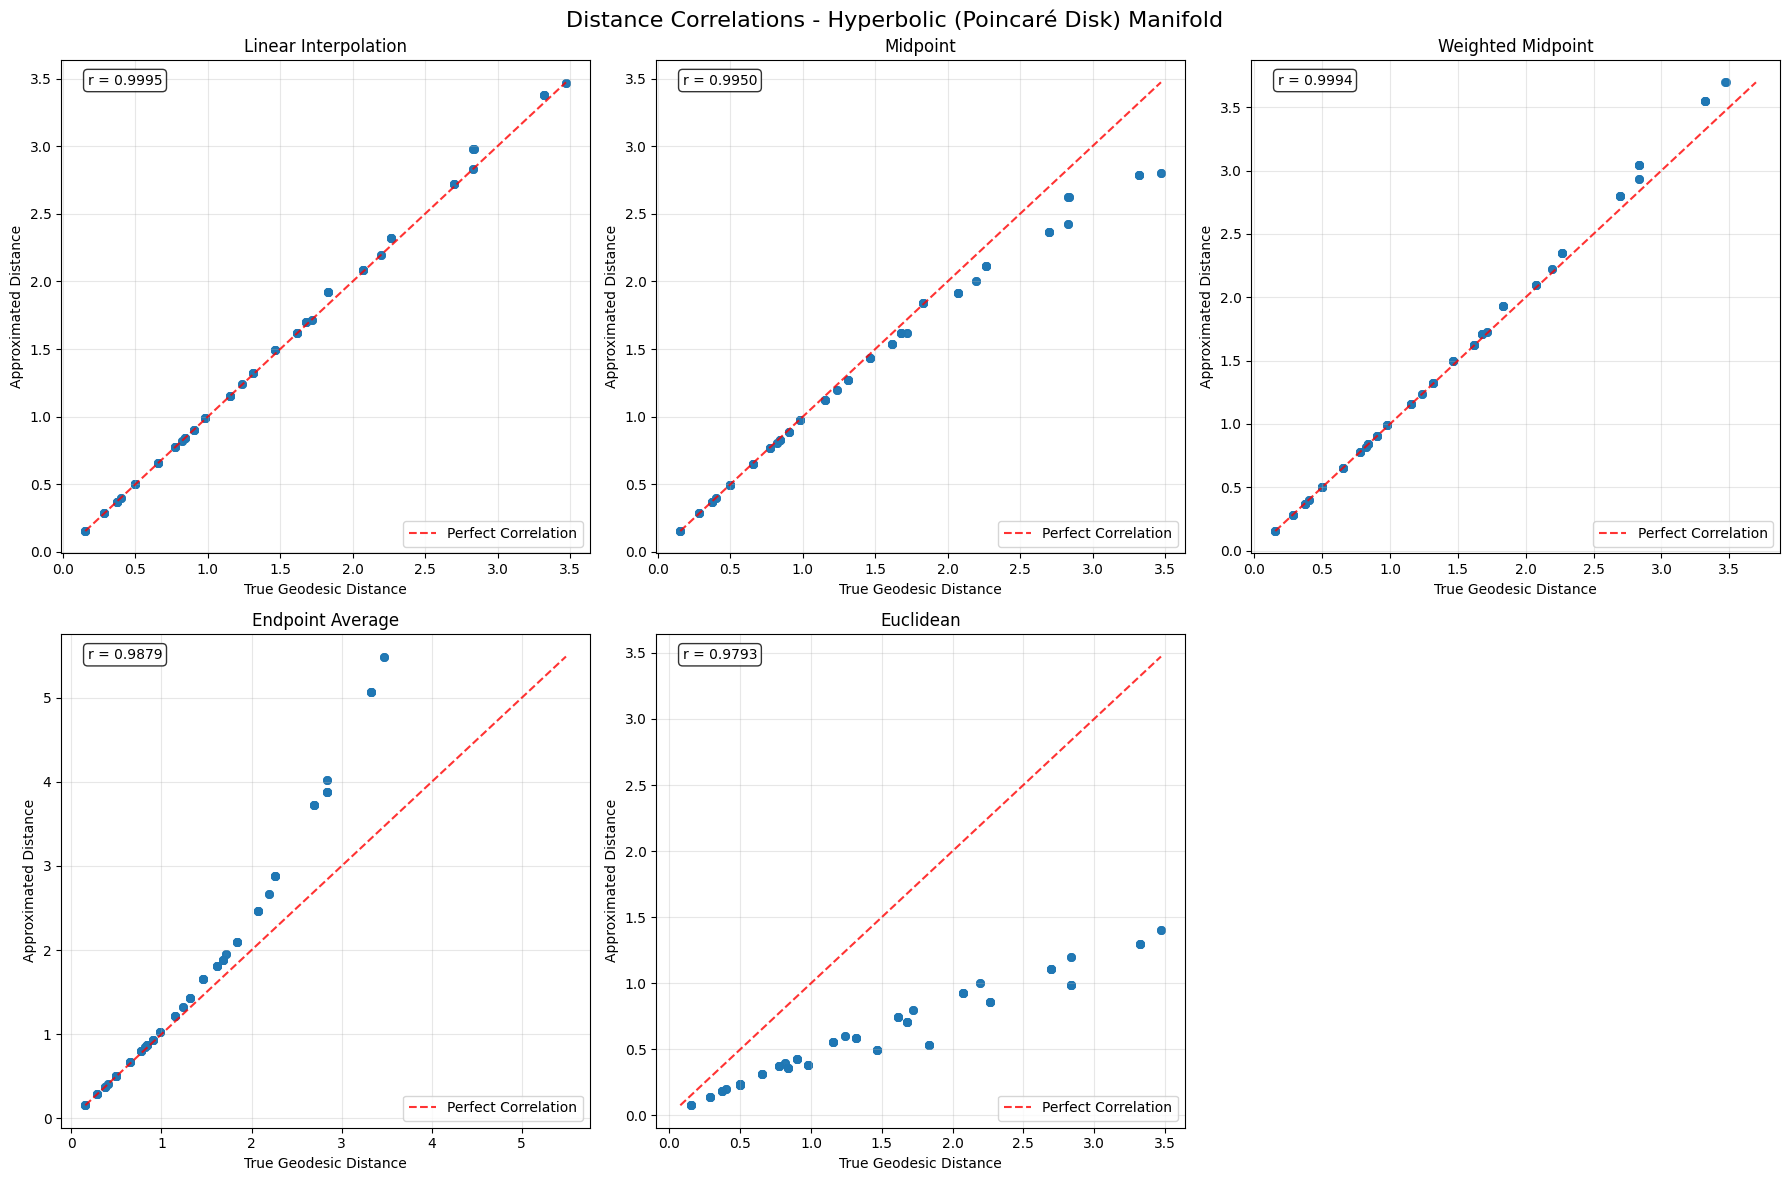

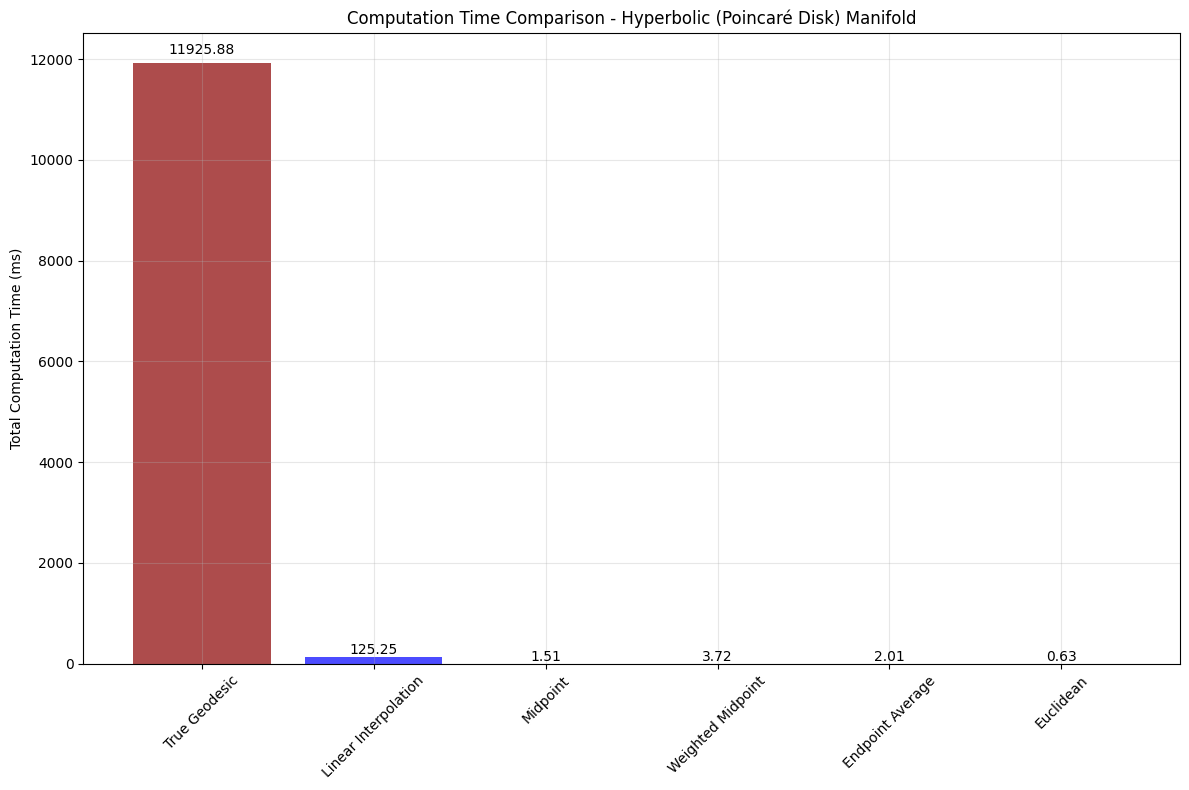

Generating example geodesic visualization...


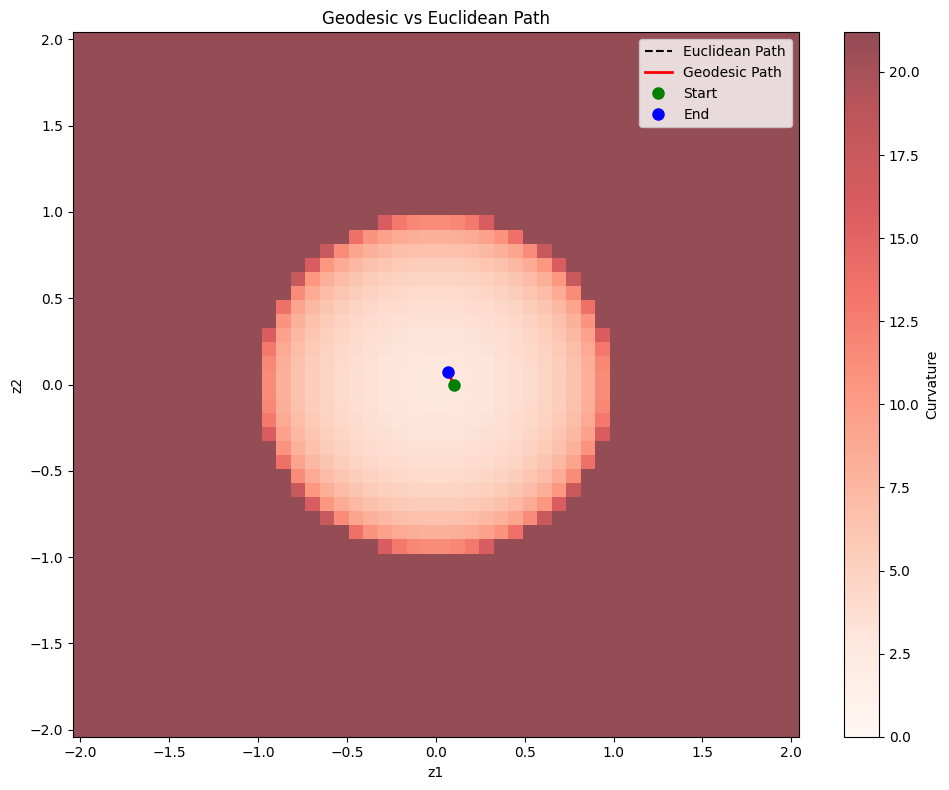


TESTING: Gaussian Bump
Testing 84 point pairs on Gaussian Bump manifold...

=== Results Summary for Gaussian Bump Manifold ===
Method               MAE        Max AE     MRE        Max RE     RMSE       Time (ms)   
--------------------------------------------------------------------------------------------
linear_interpolation 0.1596     0.9914     0.0384     0.1961     0.2844     0.6832      
midpoint             0.4932     3.2282     0.1063     0.6225     0.9217     0.0084      
weighted_midpoint    0.2214     1.7848     0.0503     0.3530     0.4344     0.0207      
endpoint_average     0.4284     3.1755     0.1030     0.4233     0.7663     0.0109      
euclidean            0.7882     3.2475     0.1997     0.5430     1.1590     0.0029      
Generating manifold curvature visualization...


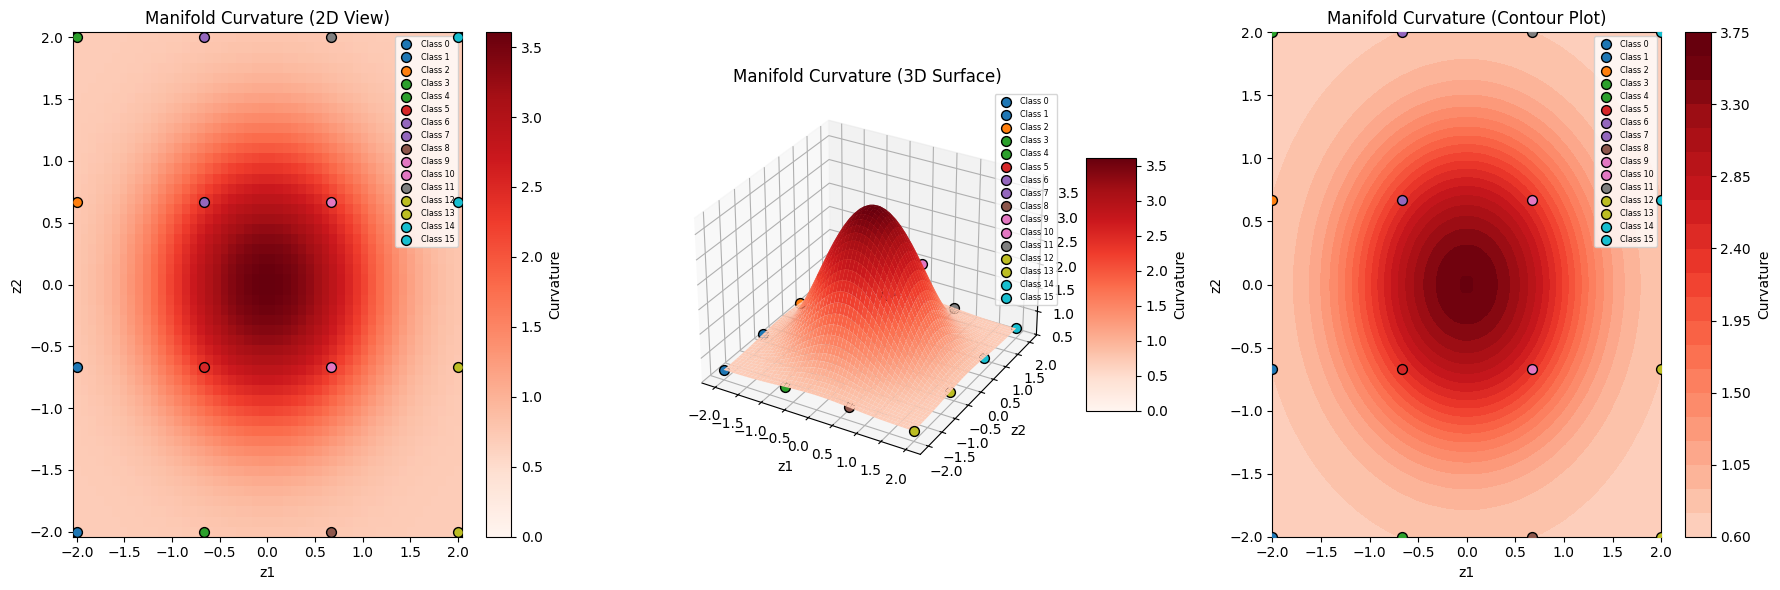

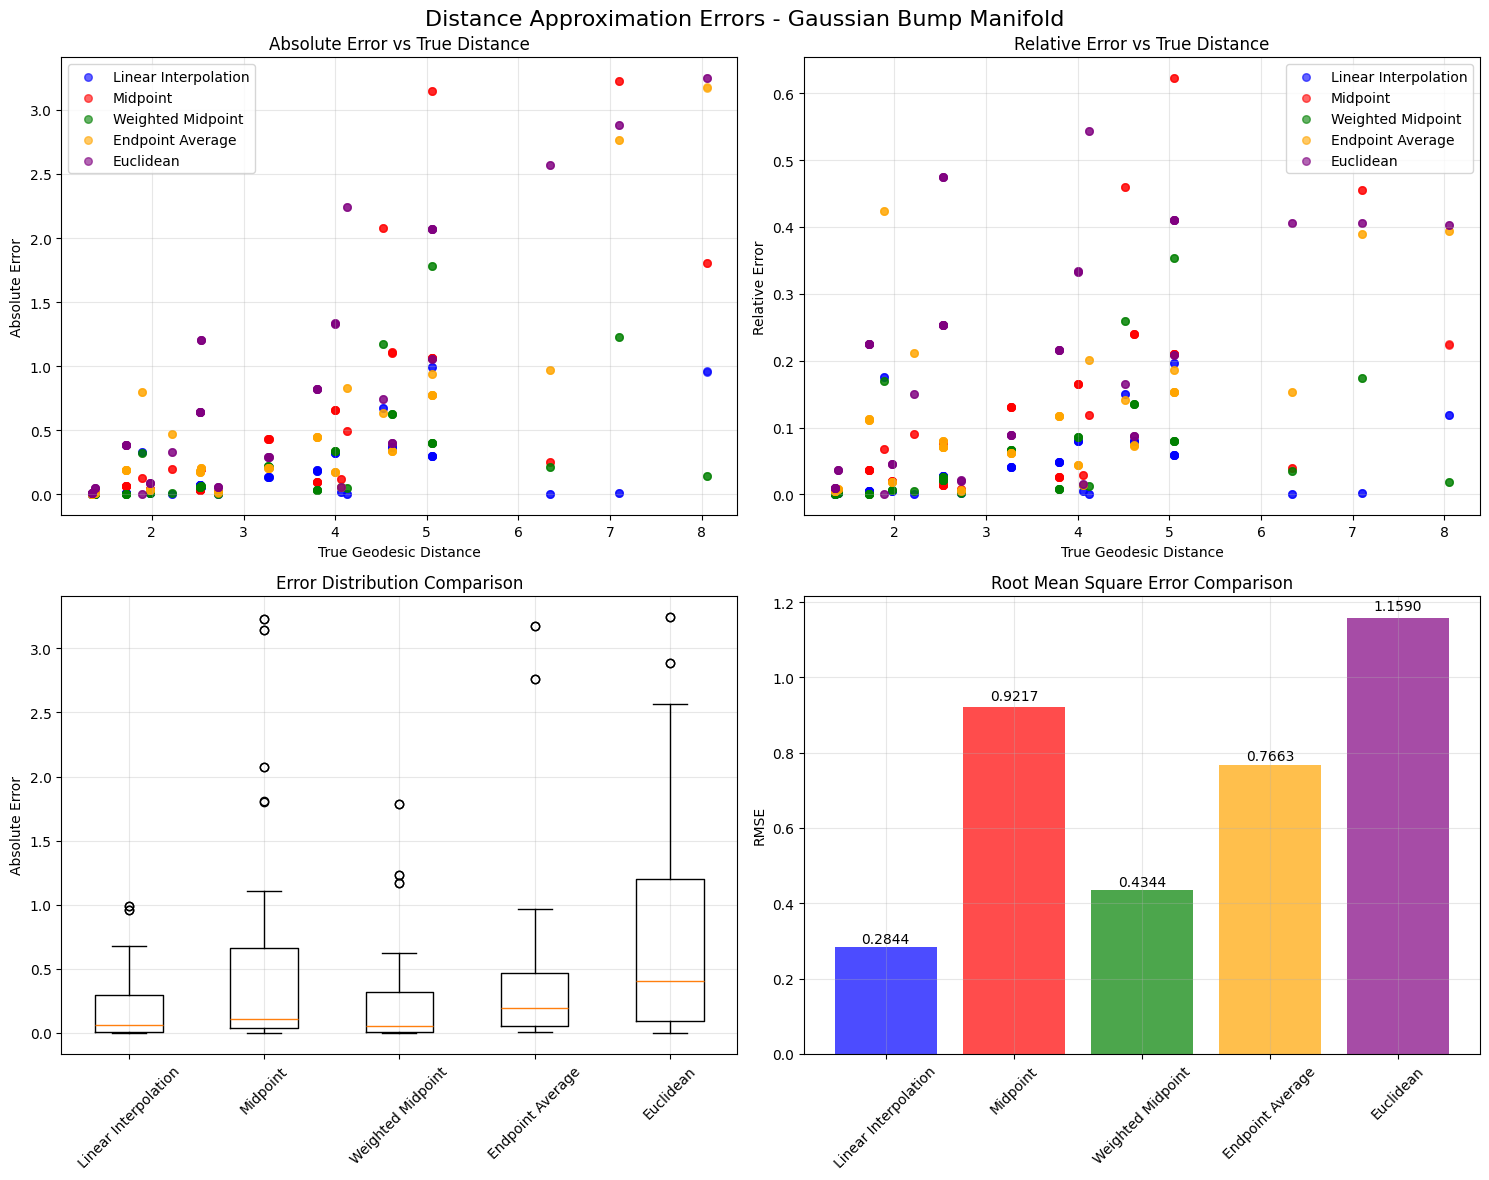

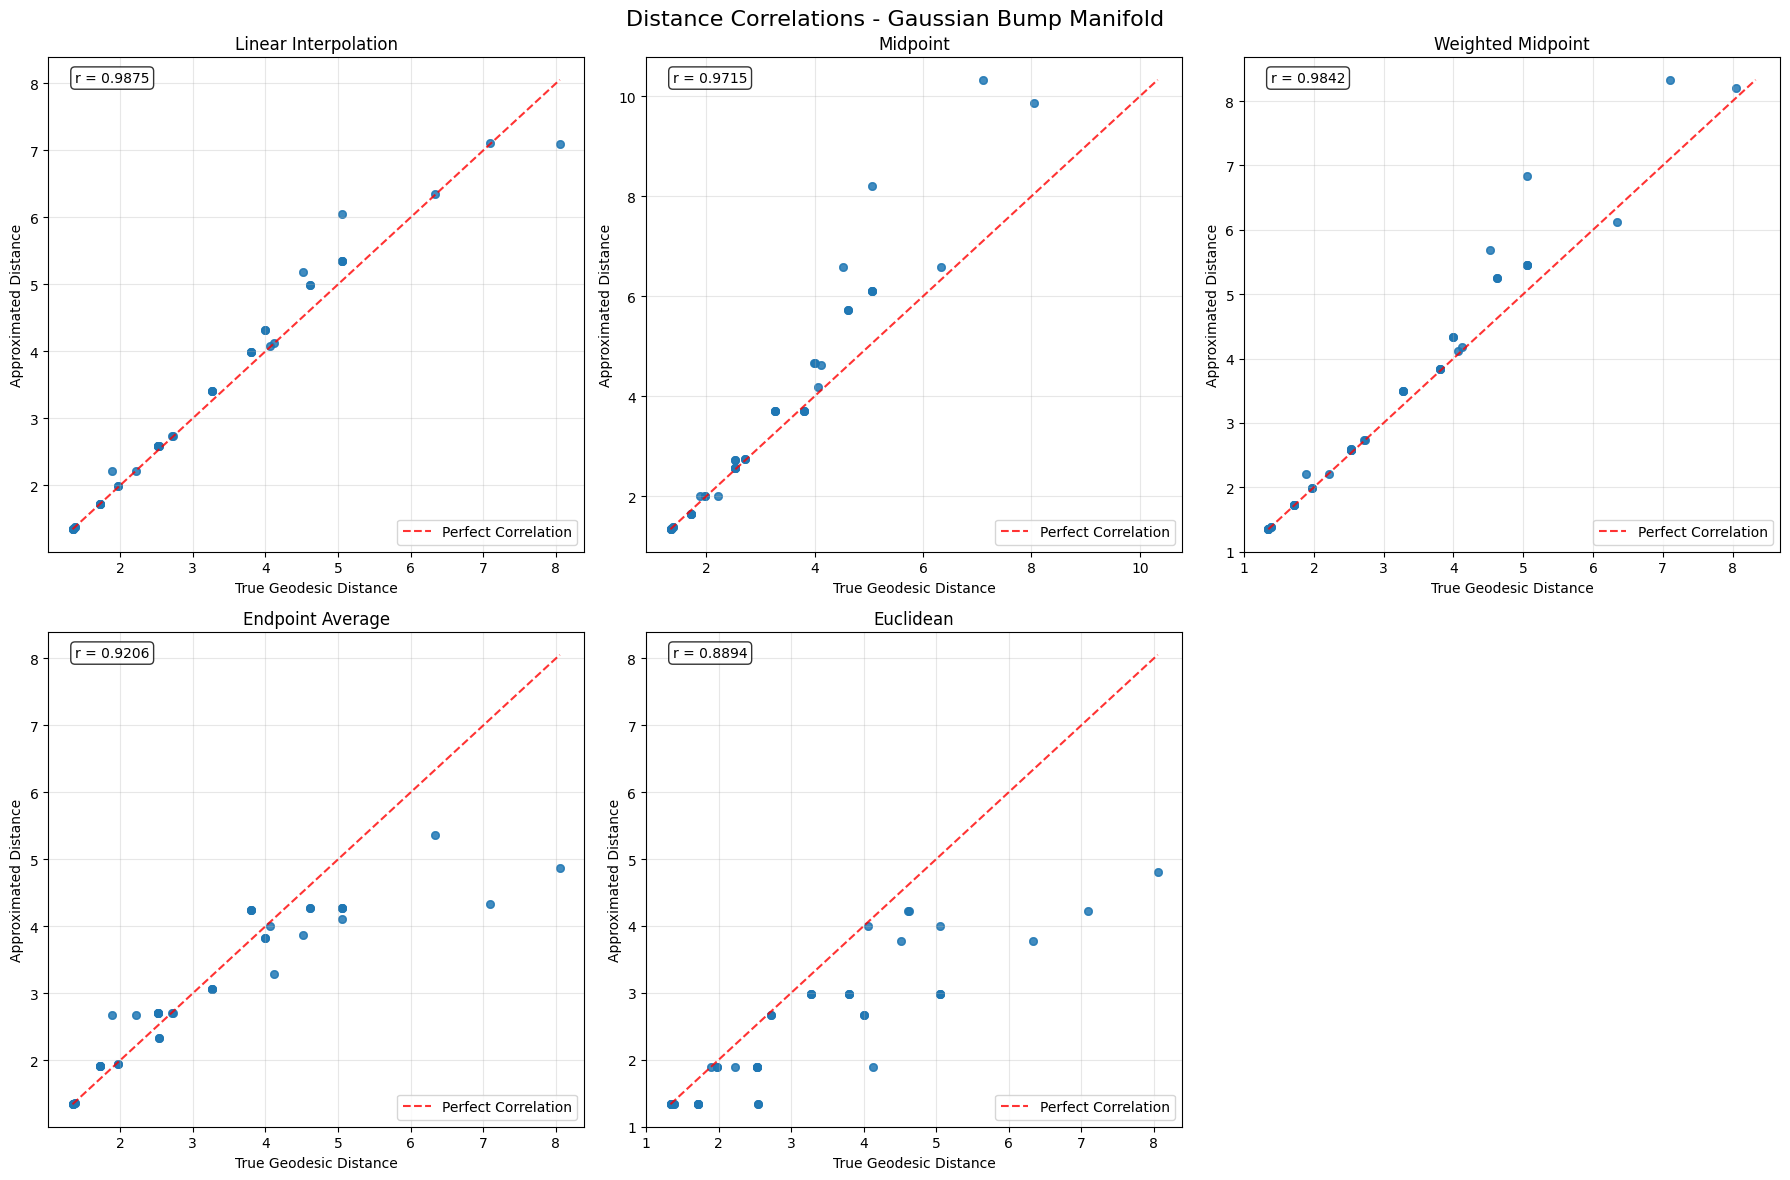

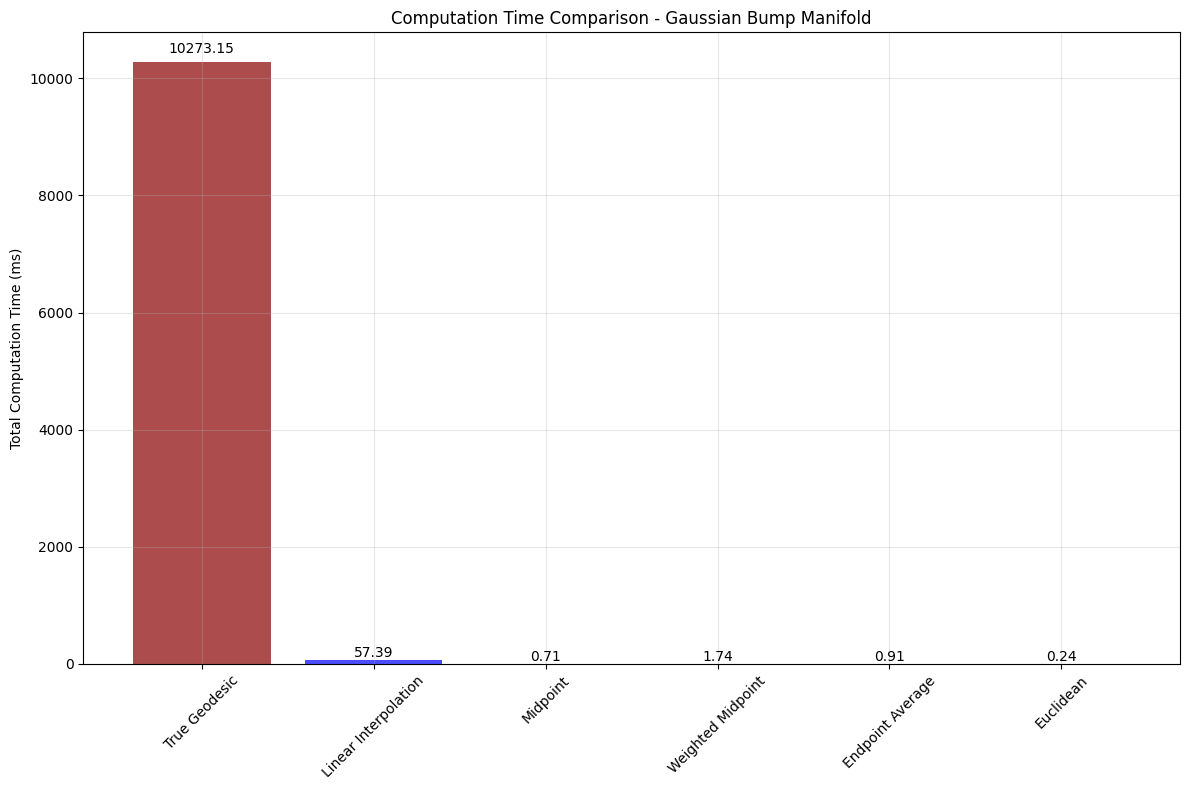

Generating example geodesic visualization...


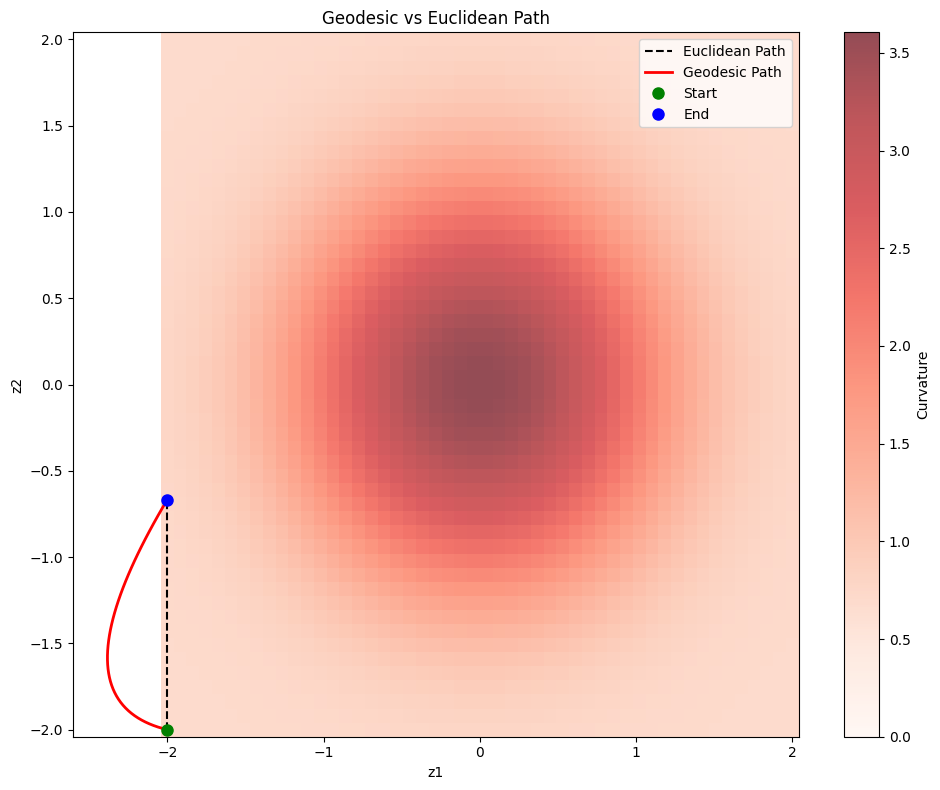


TESTING: Anisotropic
Testing 84 point pairs on Anisotropic manifold...

=== Results Summary for Anisotropic Manifold ===
Method               MAE        Max AE     MRE        Max RE     RMSE       Time (ms)   
--------------------------------------------------------------------------------------------
linear_interpolation 0.0249     0.2002     0.0076     0.0463     0.0428     1.2917      
midpoint             0.1068     0.7954     0.0316     0.1541     0.1829     0.0146      
weighted_midpoint    0.0402     0.3754     0.0114     0.0717     0.0755     0.0388      
endpoint_average     0.1116     0.5145     0.0366     0.1285     0.1654     0.0229      
euclidean            0.1961     1.0208     0.0697     0.3045     0.2811     0.0028      
Generating manifold curvature visualization...


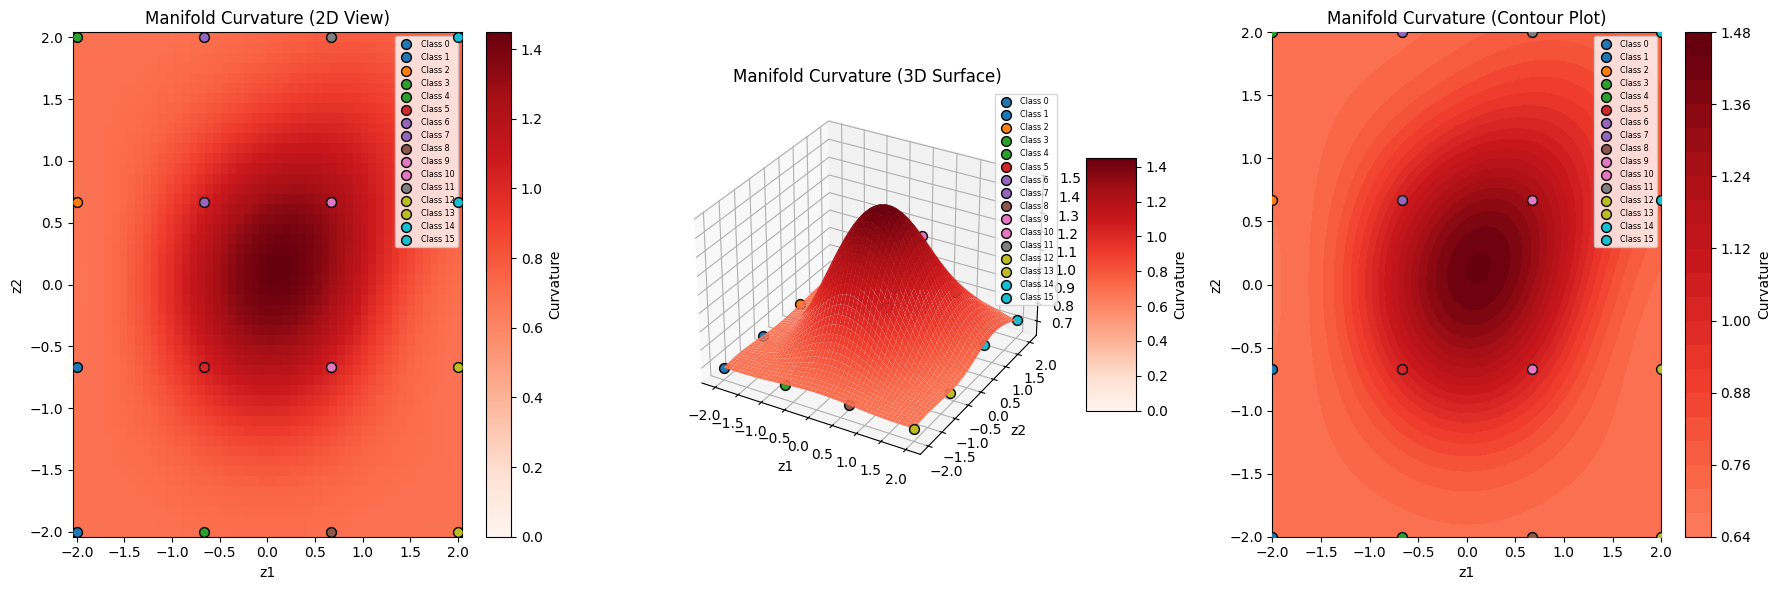

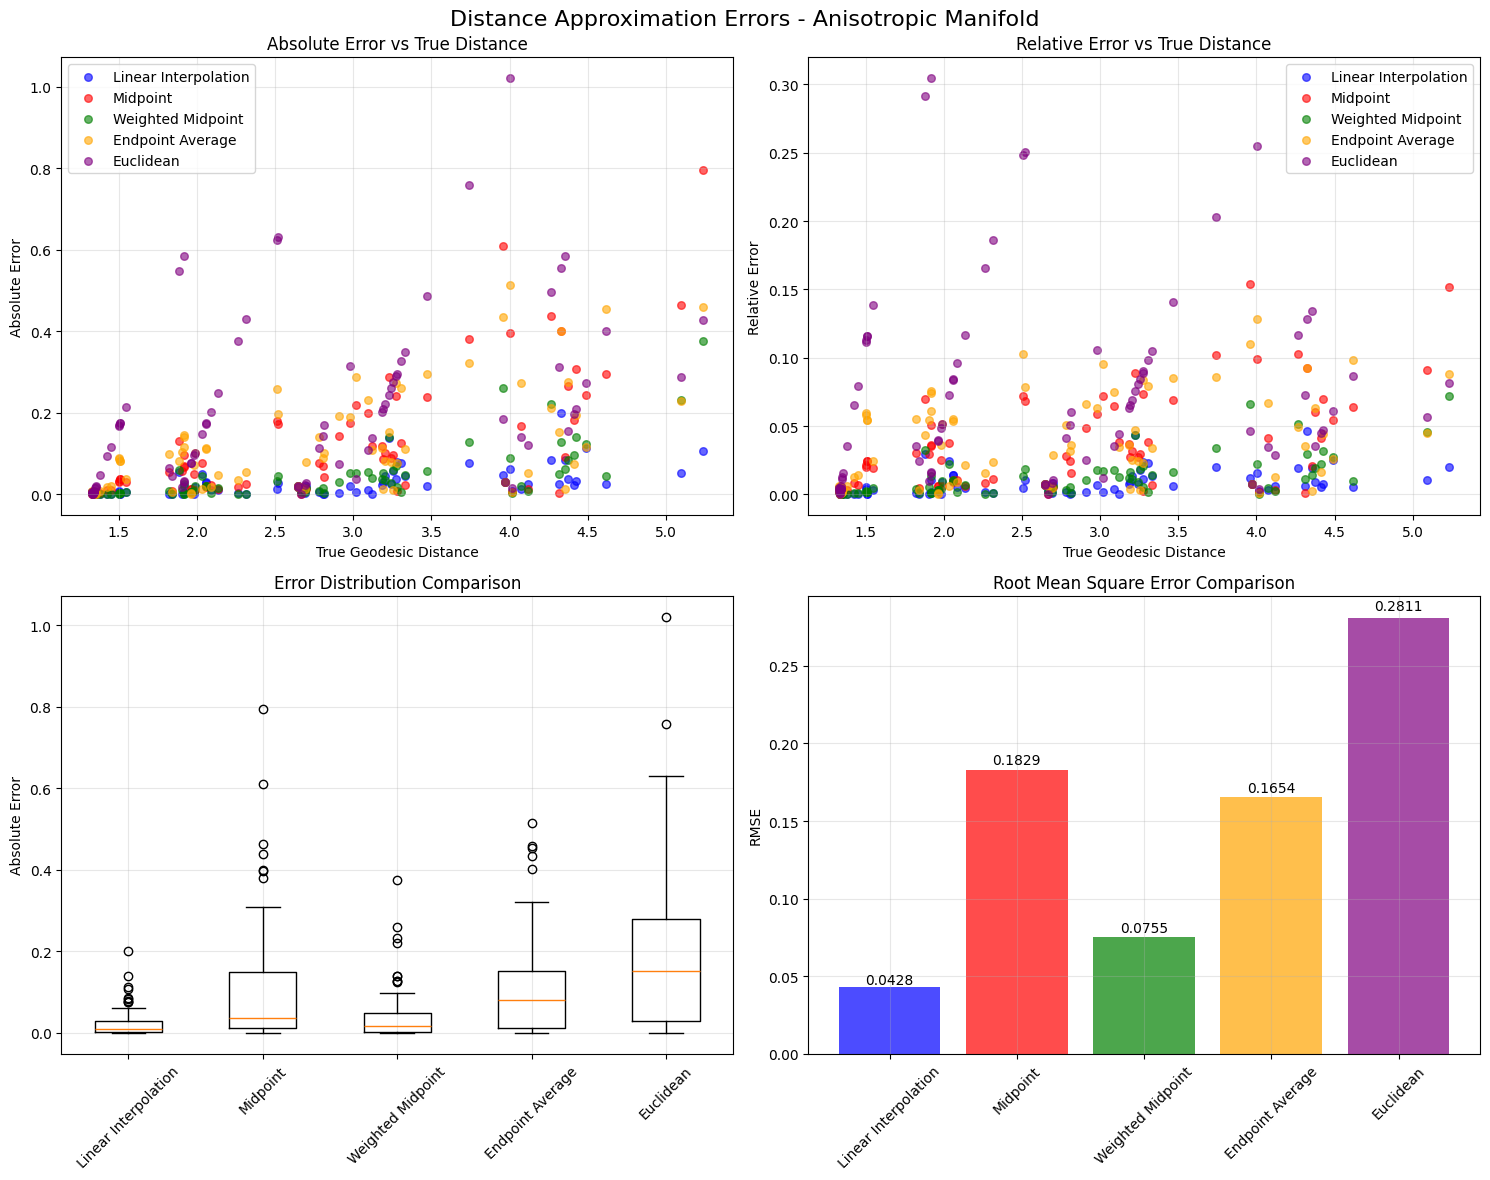

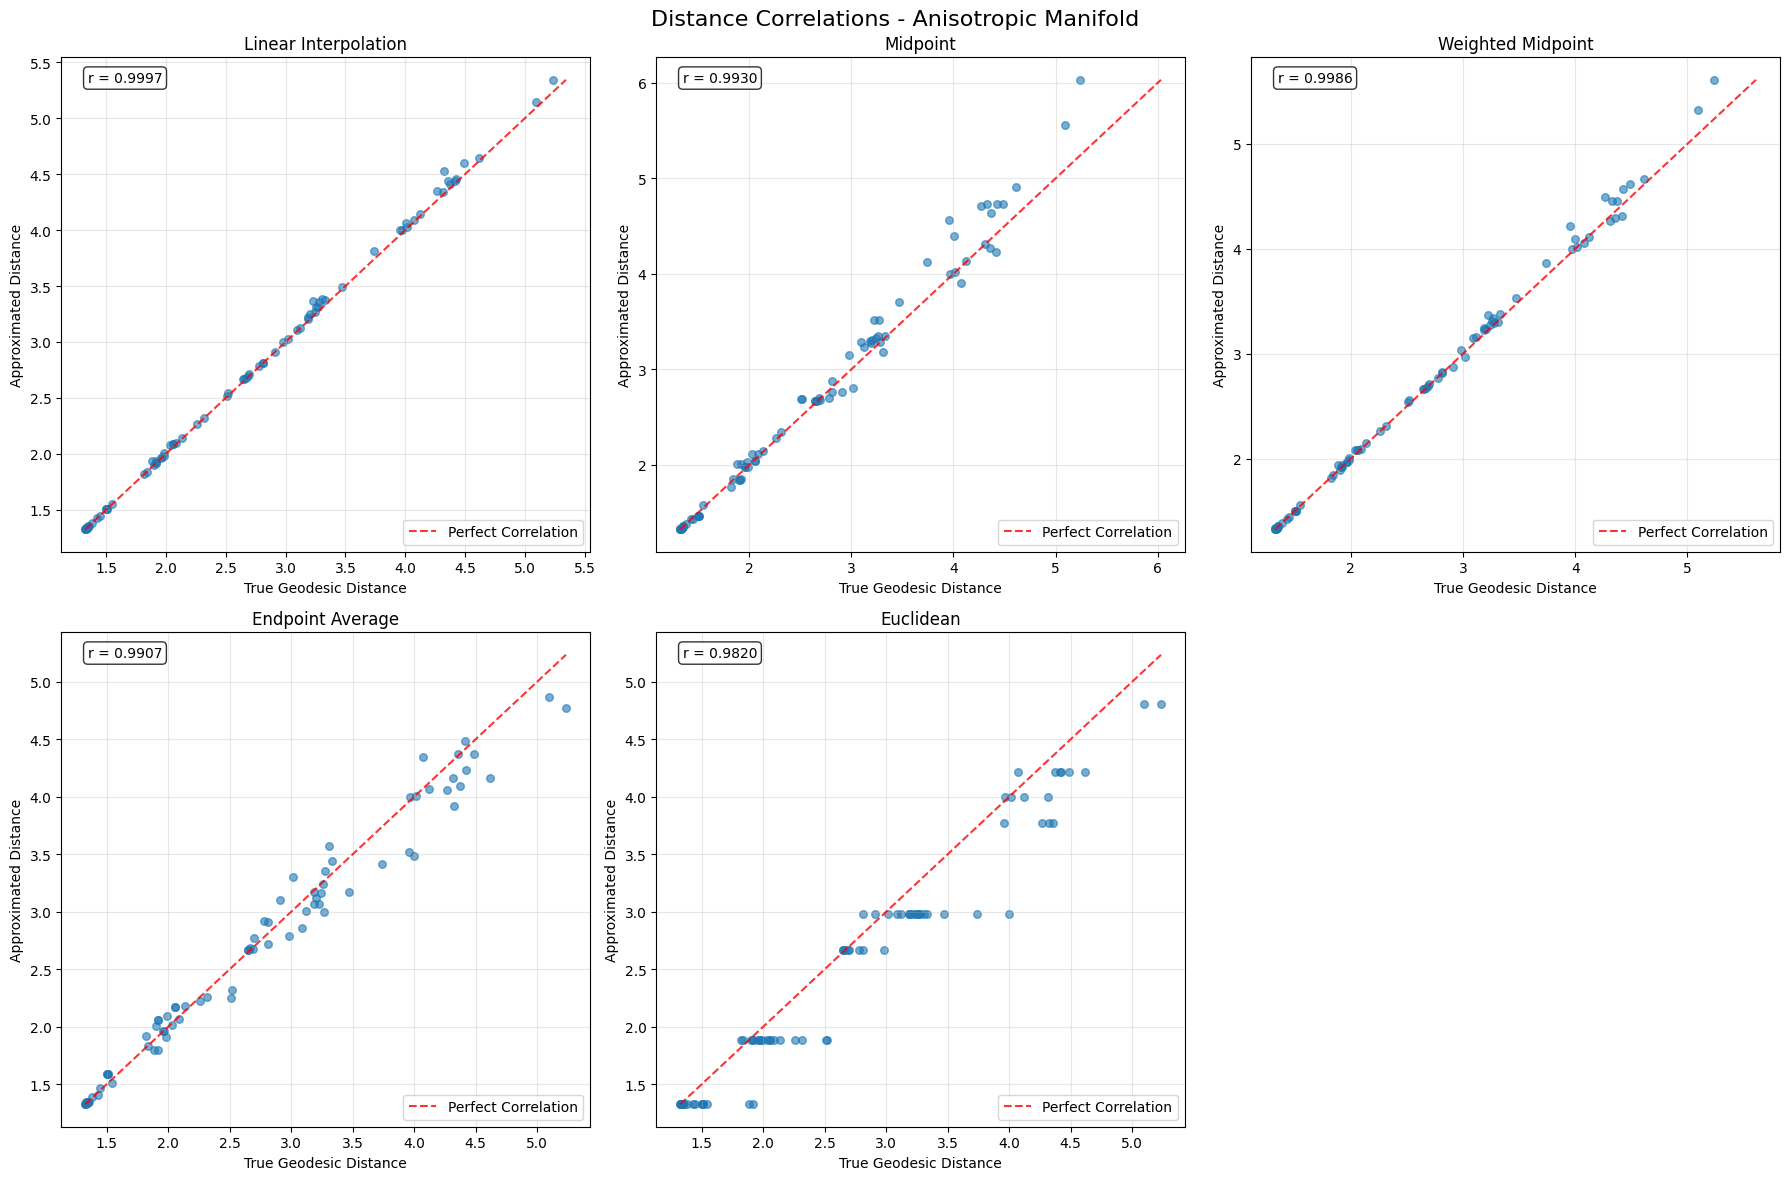

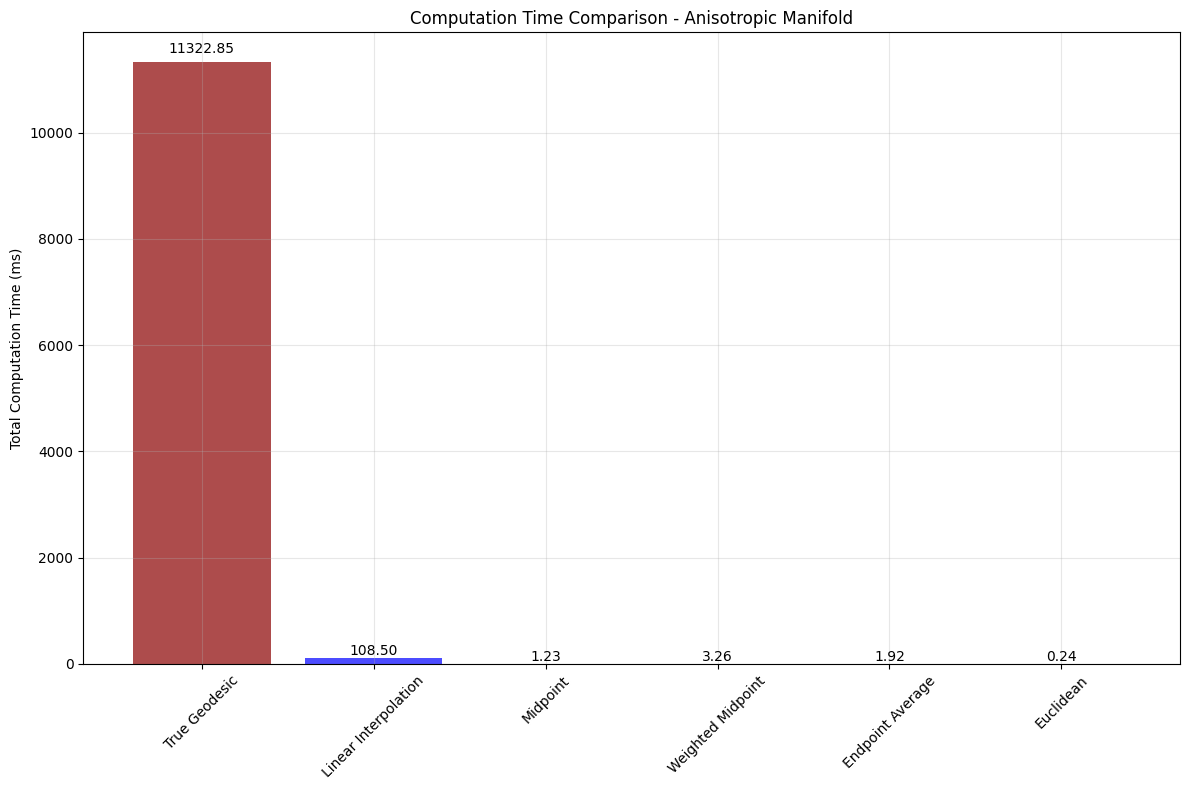

Generating example geodesic visualization...


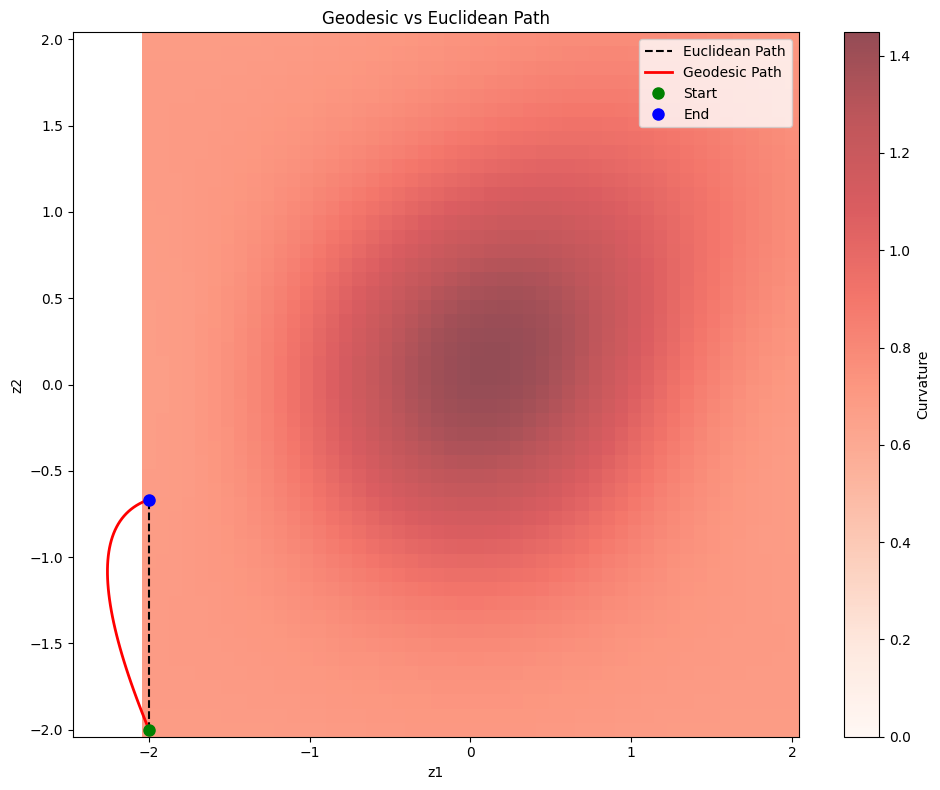


CROSS-MANIFOLD COMPARISON SUMMARY

Manifold                  Method               MAE        MRE        RMSE      
---------------------------------------------------------------------------
Hyperbolic (Poincaré Disk) linear_interpolation 0.0185     0.0085     0.0390    
Hyperbolic (Poincaré Disk) midpoint             0.0984     0.0413     0.1849    
Hyperbolic (Poincaré Disk) weighted_midpoint    0.0415     0.0166     0.0795    
Hyperbolic (Poincaré Disk) endpoint_average     0.3284     0.1358     0.6013    
Hyperbolic (Poincaré Disk) euclidean            0.8257     0.5630     1.0056    

Gaussian Bump             linear_interpolation 0.1596     0.0384     0.2844    
Gaussian Bump             midpoint             0.4932     0.1063     0.9217    
Gaussian Bump             weighted_midpoint    0.2214     0.0503     0.4344    
Gaussian Bump             endpoint_average     0.4284     0.1030     0.7663    
Gaussian Bump             euclidean            0.7882     0.1997     1.1590    

A

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from scipy.integrate import quad
from sklearn.metrics import mean_squared_error, mean_absolute_error
import time
from typing import Callable, Tuple, List
import warnings
warnings.filterwarnings('ignore')

from utils.manifolds.core import geodesic_distance, compute_gaussian_curvature
from utils.manifolds.visuals import visualize_manifold_curvature, plot_geodesics

class RiemannianManifoldExperiment:
    """
    Experiment class for comparing geodesic distance approximations on 2D Riemannian manifolds.
    """
    
    def __init__(self, metric_function: Callable, manifold_name: str = "Custom"):
        """
        Initialize the experiment with a metric function.
        
        Args:
            metric_function: Function that takes a 2D point and returns 2x2 metric tensor
            manifold_name: Name of the manifold for plotting titles
        """
        self.metric_function = metric_function
        self.manifold_name = manifold_name
        
    def linear_interpolation_distance(self, u: np.ndarray, v: np.ndarray, num_points: int = 100) -> float:
        """
        Compute distance using linear interpolation: ∫₀¹ √((u-v)ᵀg(x(t))(u-v))dt
        where x(t) = tu + (1-t)v
        
        Args:
            u, v: 2D points
            num_points: Number of integration points
        """
        def integrand(t):
            x_t = t * u + (1 - t) * v
            try:
                g = self.metric_function(x_t)
                diff = u - v
                return np.sqrt(diff.T @ g @ diff)
            except:
                return np.linalg.norm(u - v)  # Fallback to Euclidean
        
        t_vals = np.linspace(0, 1, num_points)
        dt = 1.0 / (num_points - 1)
        integral = np.trapz([integrand(t) for t in t_vals], dx=dt)
        return integral
    
    def midpoint_approximation(self, u: np.ndarray, v: np.ndarray) -> float:
        """
        Distance approximation using metric at midpoint: √((u-v)ᵀg((u+v)/2)(u-v))
        """
        midpoint = (u + v) / 2
        try:
            g = self.metric_function(midpoint)
            diff = u - v
            return np.sqrt(diff.T @ g @ diff)
        except:
            return np.linalg.norm(u - v)
    
    def weighted_midpoint_approximation(self, u: np.ndarray, v: np.ndarray, weights: List[float] = None) -> float:
        """
        Distance approximation using weighted average of metrics at multiple points.
        Default weights correspond to Simpson's rule.
        """
        if weights is None:
            weights = [1/6, 4/6, 1/6]  # Simpson's rule weights
        
        points = [u, (u + v) / 2, v]
        total_distance = 0.0
        
        for i, (point, weight) in enumerate(zip(points, weights)):
            try:
                g = self.metric_function(point)
                diff = u - v
                distance_contribution = weight * np.sqrt(diff.T @ g @ diff)
                total_distance += distance_contribution
            except:
                total_distance += weight * np.linalg.norm(u - v)
        
        return total_distance
    
    def endpoint_average_approximation(self, u: np.ndarray, v: np.ndarray) -> float:
        """
        Distance approximation using average of metrics at endpoints: √((u-v)ᵀ((g(u)+g(v))/2)(u-v))
        """
        try:
            g_u = self.metric_function(u)
            g_v = self.metric_function(v)
            g_avg = (g_u + g_v) / 2
            diff = u - v
            return np.sqrt(diff.T @ g_avg @ diff)
        except:
            return np.linalg.norm(u - v)
    
    def euclidean_distance(self, u: np.ndarray, v: np.ndarray) -> float:
        """Standard Euclidean distance for comparison."""
        return np.linalg.norm(u - v)
    
    def run_experiment(self, test_points: np.ndarray, pairs_to_test: List[Tuple[int, int]] = None, 
                      visualize: bool = True) -> dict:
        """
        Run the complete experiment comparing different distance approximations.
        
        Args:
            test_points: Array of 2D test points
            pairs_to_test: List of (i,j) index pairs to test. If None, tests all pairs.
            visualize: Whether to create visualizations
            
        Returns:
            Dictionary containing results and statistics
        """
        n_points = len(test_points)
        
        if pairs_to_test is None:
            # Generate all unique pairs
            pairs_to_test = [(i, j) for i in range(n_points) for j in range(i+1, n_points)]
        
        n_pairs = len(pairs_to_test)
        print(f"Testing {n_pairs} point pairs on {self.manifold_name} manifold...")
        
        # Initialize result arrays
        results = {
            'true_geodesic': np.zeros(n_pairs),
            'linear_interpolation': np.zeros(n_pairs),
            'midpoint': np.zeros(n_pairs),
            'weighted_midpoint': np.zeros(n_pairs),
            'endpoint_average': np.zeros(n_pairs),
            'euclidean': np.zeros(n_pairs),
            'computation_times': {}
        }
        
        # Initialize timing
        for method in ['true_geodesic', 'linear_interpolation', 'midpoint', 
                      'weighted_midpoint', 'endpoint_average', 'euclidean']:
            results['computation_times'][method] = 0.0
        
        # Compute distances using each method
        for idx, (i, j) in enumerate(pairs_to_test):
            u, v = test_points[i], test_points[j]
            
            # True geodesic distance (ground truth)
            start_time = time.time()
            try:
                results['true_geodesic'][idx] = geodesic_distance(u, v, self.metric_function)
            except Exception as e:
                print(f"Warning: Geodesic computation failed for pair ({i},{j}): {e}")
                results['true_geodesic'][idx] = np.nan
            results['computation_times']['true_geodesic'] += time.time() - start_time
            
            # Linear interpolation approximation
            start_time = time.time()
            results['linear_interpolation'][idx] = self.linear_interpolation_distance(u, v)
            results['computation_times']['linear_interpolation'] += time.time() - start_time
            
            # Midpoint approximation
            start_time = time.time()
            results['midpoint'][idx] = self.midpoint_approximation(u, v)
            results['computation_times']['midpoint'] += time.time() - start_time
            
            # Weighted midpoint approximation
            start_time = time.time()
            results['weighted_midpoint'][idx] = self.weighted_midpoint_approximation(u, v)
            results['computation_times']['weighted_midpoint'] += time.time() - start_time
            
            # Endpoint average approximation
            start_time = time.time()
            results['endpoint_average'][idx] = self.endpoint_average_approximation(u, v)
            results['computation_times']['endpoint_average'] += time.time() - start_time
            
            # Euclidean distance
            start_time = time.time()
            results['euclidean'][idx] = self.euclidean_distance(u, v)
            results['computation_times']['euclidean'] += time.time() - start_time
        
        # Remove NaN values for analysis
        valid_mask = ~np.isnan(results['true_geodesic'])
        if not np.all(valid_mask):
            print(f"Warning: {np.sum(~valid_mask)} geodesic computations failed and will be excluded from analysis")
        
        # Compute error statistics
        stats = self._compute_error_statistics(results, valid_mask)
        results['statistics'] = stats
        results['test_points'] = test_points
        results['pairs_tested'] = pairs_to_test
        
        # Print results summary
        self._print_results_summary(stats)
        
        # Create visualizations
        if visualize:
            self._create_visualizations(results, test_points, valid_mask)
        
        return results
    
    def _compute_error_statistics(self, results: dict, valid_mask: np.ndarray) -> dict:
        """Compute error statistics for each approximation method."""
        stats = {}
        true_distances = results['true_geodesic'][valid_mask]
        
        methods = ['linear_interpolation', 'midpoint', 'weighted_midpoint', 'endpoint_average', 'euclidean']
        
        for method in methods:
            approx_distances = results[method][valid_mask]
            
            # Absolute errors
            abs_errors = np.abs(approx_distances - true_distances)
            
            # Relative errors (avoid division by zero)
            rel_errors = abs_errors / np.maximum(true_distances, 1e-10)
            
            stats[method] = {
                'mean_absolute_error': np.mean(abs_errors),
                'max_absolute_error': np.max(abs_errors),
                'mean_relative_error': np.mean(rel_errors),
                'max_relative_error': np.max(rel_errors),
                'rmse': np.sqrt(np.mean(abs_errors**2)),
                'mean_computation_time': results['computation_times'][method] / len(approx_distances)
            }
        
        return stats
    
    def _print_results_summary(self, stats: dict):
        """Print a summary of the experimental results."""
        print(f"\n=== Results Summary for {self.manifold_name} Manifold ===")
        print(f"{'Method':<20} {'MAE':<10} {'Max AE':<10} {'MRE':<10} {'Max RE':<10} {'RMSE':<10} {'Time (ms)':<12}")
        print("-" * 92)
        
        for method, method_stats in stats.items():
            print(f"{method:<20} "
                  f"{method_stats['mean_absolute_error']:<10.4f} "
                  f"{method_stats['max_absolute_error']:<10.4f} "
                  f"{method_stats['mean_relative_error']:<10.4f} "
                  f"{method_stats['max_relative_error']:<10.4f} "
                  f"{method_stats['rmse']:<10.4f} "
                  f"{method_stats['mean_computation_time']*1000:<12.4f}")
    
    def _create_visualizations(self, results: dict, test_points: np.ndarray, valid_mask: np.ndarray):
        """Create comprehensive visualizations of the experimental results."""
        
        # 1. Visualize the manifold curvature with test points
        print("Generating manifold curvature visualization...")
        labels = np.arange(len(test_points))  # Simple labels for points
        curvature, Z1, Z2 = visualize_manifold_curvature(
            self.metric_function, 
            z_range=[(-2, 2), (-2, 2)], 
            resolution=50,
            data_points=test_points,
            labels=labels
        )
        
        # 2. Error comparison plots
        self._plot_error_comparisons(results, valid_mask)
        
        # 3. Distance correlation plots
        self._plot_distance_correlations(results, valid_mask)
        
        # 4. Computation time comparison
        self._plot_computation_times(results)
        
        # 5. Example geodesic visualization
        if len(test_points) >= 2:
            print("Generating example geodesic visualization...")
            plot_geodesics(self.metric_function, test_points[0], test_points[1], curvature, Z1, Z2)
    
    def _plot_error_comparisons(self, results: dict, valid_mask: np.ndarray):
        """Create error comparison plots."""
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        fig.suptitle(f'Distance Approximation Errors - {self.manifold_name} Manifold', fontsize=16)
        
        true_distances = results['true_geodesic'][valid_mask]
        methods = ['linear_interpolation', 'midpoint', 'weighted_midpoint', 'endpoint_average', 'euclidean']
        colors = ['blue', 'red', 'green', 'orange', 'purple']
        
        # Absolute errors vs true distance
        ax = axes[0, 0]
        for method, color in zip(methods, colors):
            approx_distances = results[method][valid_mask]
            abs_errors = np.abs(approx_distances - true_distances)
            ax.scatter(true_distances, abs_errors, alpha=0.6, label=method.replace('_', ' ').title(), 
                      color=color, s=30)
        ax.set_xlabel('True Geodesic Distance')
        ax.set_ylabel('Absolute Error')
        ax.set_title('Absolute Error vs True Distance')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # Relative errors vs true distance
        ax = axes[0, 1]
        for method, color in zip(methods, colors):
            approx_distances = results[method][valid_mask]
            rel_errors = np.abs(approx_distances - true_distances) / np.maximum(true_distances, 1e-10)
            ax.scatter(true_distances, rel_errors, alpha=0.6, label=method.replace('_', ' ').title(), 
                      color=color, s=30)
        ax.set_xlabel('True Geodesic Distance')
        ax.set_ylabel('Relative Error')
        ax.set_title('Relative Error vs True Distance')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # Error distribution (box plot)
        ax = axes[1, 0]
        error_data = []
        labels_list = []
        for method in methods:
            approx_distances = results[method][valid_mask]
            abs_errors = np.abs(approx_distances - true_distances)
            error_data.append(abs_errors)
            labels_list.append(method.replace('_', ' ').title())
        
        ax.boxplot(error_data, labels=labels_list)
        ax.set_ylabel('Absolute Error')
        ax.set_title('Error Distribution Comparison')
        ax.tick_params(axis='x', rotation=45)
        ax.grid(True, alpha=0.3)
        
        # RMSE comparison bar plot
        ax = axes[1, 1]
        rmse_values = [results['statistics'][method]['rmse'] for method in methods]
        bars = ax.bar(labels_list, rmse_values, color=colors, alpha=0.7)
        ax.set_ylabel('RMSE')
        ax.set_title('Root Mean Square Error Comparison')
        ax.tick_params(axis='x', rotation=45)
        ax.grid(True, alpha=0.3)
        
        # Add value labels on bars
        for bar, rmse in zip(bars, rmse_values):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                   f'{rmse:.4f}', ha='center', va='bottom', fontsize=10)
        
        plt.tight_layout()
        plt.show()
    
    def _plot_distance_correlations(self, results: dict, valid_mask: np.ndarray):
        """Create correlation plots between approximated and true distances."""
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        fig.suptitle(f'Distance Correlations - {self.manifold_name} Manifold', fontsize=16)
        
        true_distances = results['true_geodesic'][valid_mask]
        methods = ['linear_interpolation', 'midpoint', 'weighted_midpoint', 'endpoint_average', 'euclidean']
        
        for idx, method in enumerate(methods):
            row, col = divmod(idx, 3)
            ax = axes[row, col]
            
            approx_distances = results[method][valid_mask]
            
            # Scatter plot
            ax.scatter(true_distances, approx_distances, alpha=0.6, s=30)
            
            # Perfect correlation line
            min_dist, max_dist = min(np.min(true_distances), np.min(approx_distances)), \
                                max(np.max(true_distances), np.max(approx_distances))
            ax.plot([min_dist, max_dist], [min_dist, max_dist], 'r--', alpha=0.8, label='Perfect Correlation')
            
            # Correlation coefficient
            corr_coef = np.corrcoef(true_distances, approx_distances)[0, 1]
            ax.text(0.05, 0.95, f'r = {corr_coef:.4f}', transform=ax.transAxes, 
                   bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
            
            ax.set_xlabel('True Geodesic Distance')
            ax.set_ylabel('Approximated Distance')
            ax.set_title(method.replace('_', ' ').title())
            ax.legend()
            ax.grid(True, alpha=0.3)
        
        # Remove empty subplot
        axes[1, 2].remove()
        
        plt.tight_layout()
        plt.show()
    
    def _plot_computation_times(self, results: dict):
        """Create computation time comparison plot."""
        fig, ax = plt.subplots(figsize=(12, 8))
        
        methods = ['true_geodesic', 'linear_interpolation', 'midpoint', 'weighted_midpoint', 'endpoint_average', 'euclidean']
        times = [results['computation_times'][method] * 1000 for method in methods]  # Convert to milliseconds
        labels = [method.replace('_', ' ').title() for method in methods]
        colors = ['darkred', 'blue', 'red', 'green', 'orange', 'purple']
        
        bars = ax.bar(labels, times, color=colors, alpha=0.7)
        ax.set_ylabel('Total Computation Time (ms)')
        ax.set_title(f'Computation Time Comparison - {self.manifold_name} Manifold')
        ax.tick_params(axis='x', rotation=45)
        ax.grid(True, alpha=0.3)
        
        # Add value labels on bars
        for bar, time_val in zip(bars, times):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                   f'{time_val:.2f}', ha='center', va='bottom', fontsize=10)
        
        plt.tight_layout()
        plt.show()


# Example manifolds for testing
def hyperbolic_metric(z: np.ndarray) -> np.ndarray:
    """
    Hyperbolic metric in Poincaré disk model: g = (4/(1-|z|²)²)I
    High curvature near boundary.
    """
    r_squared = np.sum(z**2)
    if r_squared >= 0.99:  # Avoid singularity at boundary
        r_squared = 0.99
    
    factor = 4.0 / (1 - r_squared)**2
    return factor * np.eye(2)

def gaussian_bump_metric(z: np.ndarray) -> np.ndarray:
    """
    Metric with Gaussian-shaped distortion: g = (1 + α*exp(-|z|²/σ²))I
    Creates a region of high curvature around the origin.
    """
    alpha = 5.0  # Strength of distortion
    sigma = 1.0  # Width of distortion
    r_squared = np.sum(z**2)
    
    factor = 1.0 + alpha * np.exp(-r_squared / (sigma**2))
    return factor * np.eye(2)

def anisotropic_metric(z: np.ndarray) -> np.ndarray:
    """
    Anisotropic metric with different scaling in x and y directions.
    """
    x, y = z[0], z[1]
    
    # Create anisotropy that varies with position
    g11 = 1.0 + 2.0 * np.exp(-(x**2 + y**2))
    g22 = 1.0 + 0.5 * np.exp(-((x-1)**2 + (y-1)**2))
    g12 = 0.3 * np.sin(x) * np.cos(y)  # Off-diagonal term
    
    G = np.array([[g11, g12], [g12, g22]])
    
    # Ensure positive definiteness
    eigenvals = np.linalg.eigvals(G)
    if np.min(eigenvals) <= 0:
        G += (0.1 - np.min(eigenvals)) * np.eye(2)
    
    return G


def run_comprehensive_experiment():
    """
    Run comprehensive experiments on multiple manifold types.
    """
    print("=" * 80)
    print("COMPREHENSIVE RIEMANNIAN MANIFOLD DISTANCE APPROXIMATION EXPERIMENT")
    print("=" * 80)
    
    # Define test manifolds
    manifolds = [
        (hyperbolic_metric, "Hyperbolic (Poincaré Disk)"),
        (gaussian_bump_metric, "Gaussian Bump"),
        (anisotropic_metric, "Anisotropic")
    ]
    
    # Generate test points for each manifold
    np.random.seed(42)  # For reproducibility
    
    all_results = {}
    
    for metric_func, name in manifolds:
        print(f"\n{'='*60}")
        print(f"TESTING: {name}")
        print(f"{'='*60}")
        
        # Generate appropriate test points for each manifold
        if "Hyperbolic" in name:
            # Points within the Poincaré disk (|z| < 1)
            angles = np.linspace(0, 2*np.pi, 8, endpoint=False)
            radii = [0.1, 0.3, 0.5, 0.7]
            test_points = []
            for r in radii:
                for angle in angles:
                    test_points.append([r * np.cos(angle), r * np.sin(angle)])
            test_points = np.array(test_points)
        else:
            # Regular grid for other manifolds
            x_vals = np.linspace(-2, 2, 4)
            y_vals = np.linspace(-2, 2, 4)
            test_points = np.array([[x, y] for x in x_vals for y in y_vals])
        
        # Create experiment instance
        experiment = RiemannianManifoldExperiment(metric_func, name)
        
        # Run experiment with a subset of point pairs for efficiency
        n_points = len(test_points)
        pairs_to_test = [(i, j) for i in range(n_points) for j in range(i+1, min(i+8, n_points))]
        
        # Run the experiment
        results = experiment.run_experiment(test_points, pairs_to_test, visualize=True)
        all_results[name] = results
    
    # Create summary comparison across manifolds
    create_manifold_comparison_summary(all_results)
    
    return all_results


def create_manifold_comparison_summary(all_results: dict):
    """Create a summary comparison across different manifolds."""
    print(f"\n{'='*80}")
    print("CROSS-MANIFOLD COMPARISON SUMMARY")
    print(f"{'='*80}")
    
    methods = ['linear_interpolation', 'midpoint', 'weighted_midpoint', 'endpoint_average', 'euclidean']
    
    # Summary table
    print(f"\n{'Manifold':<25} {'Method':<20} {'MAE':<10} {'MRE':<10} {'RMSE':<10}")
    print("-" * 75)
    
    best_methods = {}
    
    for manifold_name, results in all_results.items():
        best_mae = float('inf')
        best_method = ""
        
        for method in methods:
            stats = results['statistics'][method]
            mae = stats['mean_absolute_error']
            mre = stats['mean_relative_error']
            rmse = stats['rmse']
            
            print(f"{manifold_name:<25} {method:<20} {mae:<10.4f} {mre:<10.4f} {rmse:<10.4f}")
            
            if mae < best_mae:
                best_mae = mae
                best_method = method
        
        best_methods[manifold_name] = (best_method, best_mae)
        print()
    
    print(f"\n{'='*60}")
    print("BEST PERFORMING METHODS BY MANIFOLD:")
    print(f"{'='*60}")
    for manifold, (method, mae) in best_methods.items():
        print(f"{manifold:<25}: {method.replace('_', ' ').title()} (MAE: {mae:.4f})")


if __name__ == "__main__":
    # Run the comprehensive experiment
    results = run_comprehensive_experiment()
    
    print(f"\n{'='*80}")
    print("EXPERIMENT COMPLETED SUCCESSFULLY!")
    print(f"{'='*80}")